In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, '../tools/')

from tools import * 

In [2]:
config = pd.Series({
    'path': os.path.abspath('../dades'),
    'file_type':'csv',
    'years':[2023],
    'dataset': 'BicingNou_ESTACIONS_CLEAN'
})


In [3]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:38843 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 16.44 GB


# Read data

In [4]:
%%time

data = read_dask_dataframes(config.path, config.file_type, config.dataset, config.years)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 142 ms, sys: 0 ns, total: 142 ms
Wall time: 138 ms


# config_year.year 

In [5]:
config_year = pd.Series({
    'path':config.path,
    'file_type':config.file_type,
    'year':2023,
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [6]:
len(data[config_year.year].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

6

In [7]:
first_size = get_ddf_shape(data[config_year.year])

# Visualization 2022

In [8]:
%%time

data[config_year.year] = load_checkpoint(config_year)

# checkpoint reloaded.

checkpoint reloaded.
CPU times: user 15.1 ms, sys: 0 ns, total: 15.1 ms
Wall time: 14.2 ms


In [9]:
%%time

last_size = get_ddf_shape(data[config_year.year])

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(last_size[0]-first_size[0]):02d} rows')
print(f'dropped {(last_size[1]-first_size[1]):02d} columns')

Changes to dataframe durinf preprocessing
dropeed 20137 rows
dropped 04 columns
CPU times: user 97.1 ms, sys: 0 ns, total: 97.1 ms
Wall time: 995 ms


In [10]:
len(data[config_year.year].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

11

In [11]:
%%time

nans = get_features_nans(data[config_year.year])

zeros = get_features_zero(data[config_year.year])

CPU times: user 390 ms, sys: 0 ns, total: 390 ms
Wall time: 3.82 s


In [12]:
nans

{}

In [13]:
zeros

{'num_bikes_available': 1.5770159697304165,
 'num_bikes_available_types.mechanical': 15.858075544790246,
 'num_bikes_available_types.ebike': 11.309725028786476,
 'num_docks_available': 0.5409355619312162,
 'status': 99.93826689994525,
 'is_installed': 0.0005236549486265403,
 'is_renting': 0.07063523418140222,
 'is_returning': 0.07057705029822149,
 'dayofweek': 14.187208971489316,
 'hour': 4.314218570084524,
 'ctx0': 0.5409355619312162,
 'ctx1': 0.5435538366743489,
 'ctx2': 0.5446593304547827,
 'ctx3': 0.5452411692865899,
 'ctx4': 0.544601146571602}

In [14]:
# nuniques = get_columns_nunique(data[config_year.year])

# pd.Series(nuniques)
# station_id                                  511
# num_bikes_available                        5413
# num_bikes_available_types.mechanical       4950
# num_bikes_available_types.ebike            2412
# num_docks_available                        5641
# last_reported                           3085646
# is_charging_station                           2
# status                                      264
# is_installed                                 50
# is_renting                                  230
# is_returning                                230
# timestamp                                  8700
# year                                          2
# month                                        12
# week                                         53
# dayofweek                                     7
# day                                          31
# dayofyear                                   366
# hour                                         24
# traffic                                    1741
# dtype: int64
    
uniques = get_columns_unique(data[config_year.year])

In [15]:
uniques

{'station_id': 0        1
 1       34
 2      386
 3      385
 4      384
       ... 
 503    249
 504    519
 505    106
 506    520
 507    191
 Name: station_id, Length: 508, dtype: int64,
 'num_bikes_available': 0       37.333333
 1       39.500000
 2       36.625000
 3       36.000000
 4       36.500000
           ...    
 4602    13.500000
 4603    28.954545
 4604    21.461538
 4605    31.777778
 4606    19.055556
 Name: num_bikes_available, Length: 4607, dtype: float64,
 'num_bikes_available_types.mechanical': 0       35.000000
 1       38.500000
 2       34.500000
 3       34.000000
 4       32.900000
           ...    
 3633    49.100000
 3634    49.400000
 3635    49.142857
 3636    48.625000
 3637     5.965517
 Name: num_bikes_available_types.mechanical, Length: 3638, dtype: float64,
 'num_bikes_available_types.ebike': 0        2.333333
 1        1.000000
 2        2.125000
 3        2.000000
 4        4.400000
           ...    
 2613    11.928571
 2614    26.222222
 2615  

## 2022 station_id

In [16]:
%%time

print(stats.describe(data[config_year.year].station_id))
data[config_year.year].station_id.describe().compute()

DescribeResult(nobs=1718689, minmax=(1, 520), mean=261.59162128808646, variance=22343.83658626999, skewness=-0.017182759003050396, kurtosis=-1.18854802334533)
CPU times: user 314 ms, sys: 0 ns, total: 314 ms
Wall time: 1.83 s


count    1.718689e+06
mean     2.615916e+02
std      1.494785e+02
min      1.000000e+00
25%      1.340000e+02
50%      2.820000e+02
75%      3.970000e+02
max      5.200000e+02
Name: station_id, dtype: float64

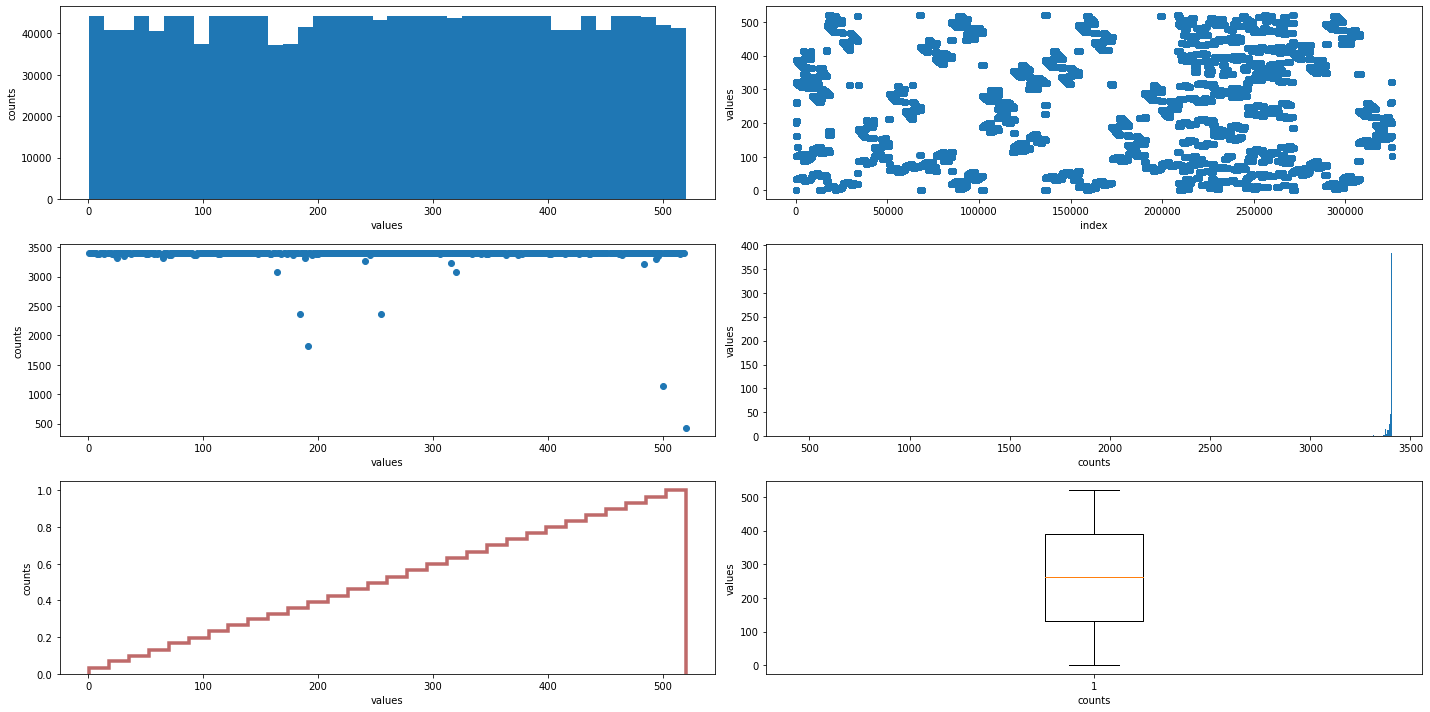

CPU times: user 4.15 s, sys: 900 ms, total: 5.05 s
Wall time: 4.54 s


In [17]:
%%time

show_counts(data[config_year.year].station_id.compute())

value counts stats {'max': 3408, 'mean': 3383.246062992126, 'median': 3408.0, 'std': 192.40389512743508, 'min': 432}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 918 ms, sys: 70.9 ms, total: 989 ms
Wall time: 5.99 s


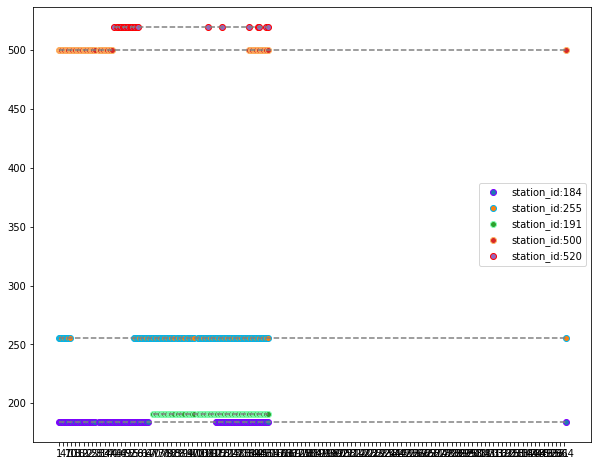

In [18]:
%%time

scatter_columns(
    data[config_year.year], 
    'dayofyear', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=np.arange(uniques['dayofyear'].min(),uniques['dayofyear'].max(), 3.0),
    figsize=(10,8)
)

## 2022 num_bikes_available

In [19]:
%%time

print(stats.describe(data[config_year.year].num_bikes_available))
data[config_year.year].num_bikes_available.describe().compute()

DescribeResult(nobs=1718689, minmax=(0.0, 54.0), mean=10.66328766568581, variance=60.93179866459276, skewness=0.8641527924357573, kurtosis=0.8899561480880043)
CPU times: user 296 ms, sys: 25.4 ms, total: 321 ms
Wall time: 1.88 s


count    1.718689e+06
mean     1.066329e+01
std      7.805882e+00
min      0.000000e+00
25%      4.333333e+00
50%      9.750000e+00
75%      1.600000e+01
max      5.400000e+01
Name: num_bikes_available, dtype: float64

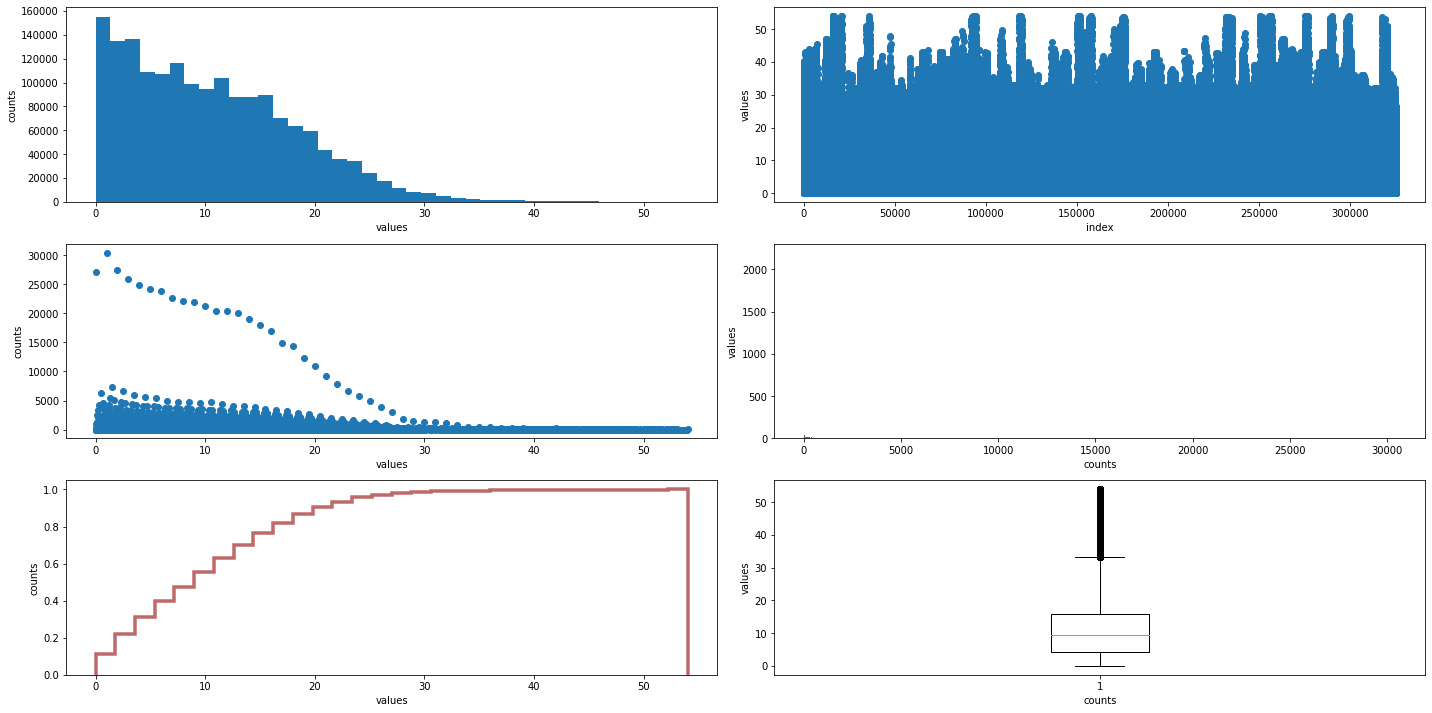

CPU times: user 8.29 s, sys: 1.64 s, total: 9.92 s
Wall time: 10.3 s


In [20]:
%%time

show_counts(data[config_year.year].num_bikes_available.compute())

135
value counts stats {'max': 3408, 'mean': 3383.246062992126, 'median': 3408.0, 'std': 192.40389512743508, 'min': 432}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 845 ms, sys: 60.1 ms, total: 905 ms
Wall time: 5.72 s


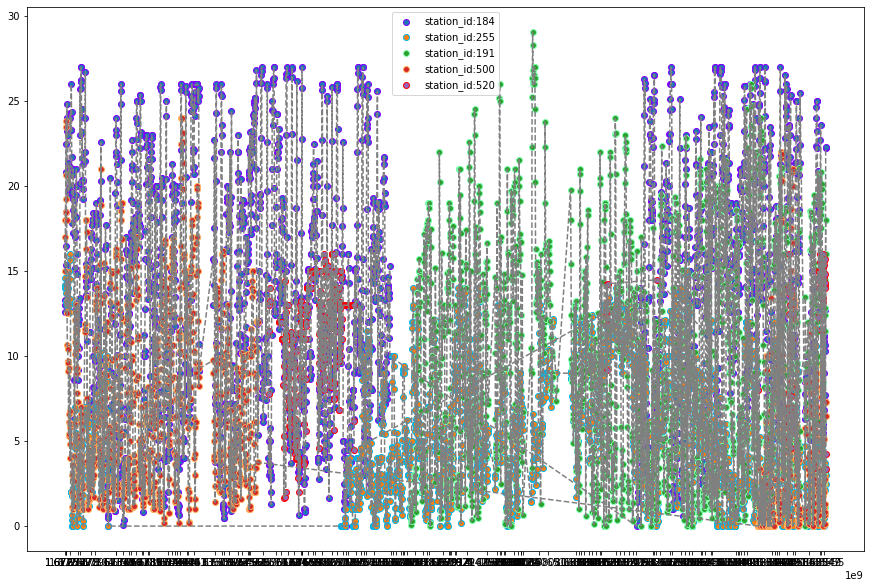

In [21]:
%%time

# Checking availibilty for docks all year
xtikcs_scatter = [uniques['timestamp'][i] for i, x in enumerate(uniques['timestamp']) if i%25==0]
print(len(xtikcs_scatter))

scatter_columns(
    data[config_year.year], 
    'timestamp', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(xtikcs_scatter),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 3408, 'mean': 3383.246062992126, 'median': 3408.0, 'std': 192.40389512743508, 'min': 432}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 692 ms, sys: 62 ms, total: 754 ms
Wall time: 5.39 s


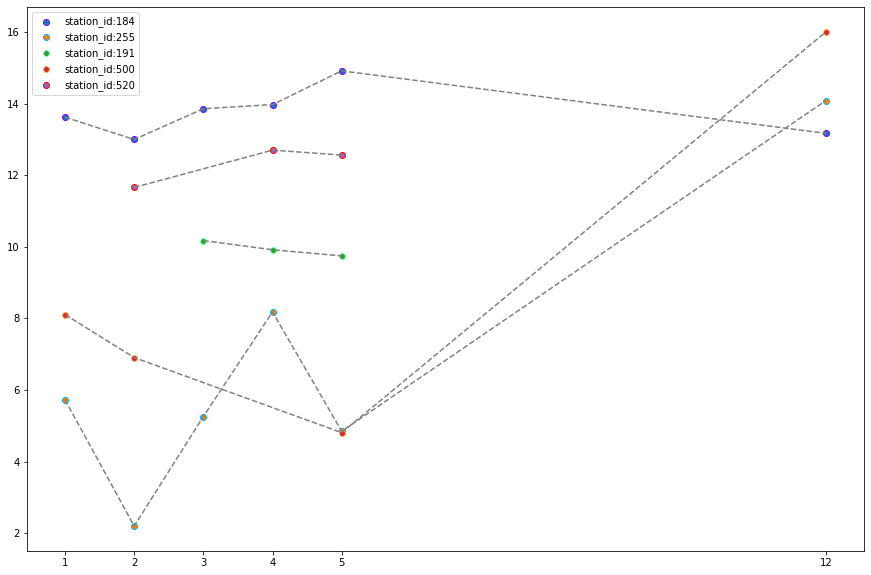

In [22]:
%%time

scatter_columns(
    data[config_year.year], 
    'month', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['month']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 3408, 'mean': 3383.246062992126, 'median': 3408.0, 'std': 192.40389512743508, 'min': 432}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 712 ms, sys: 26.3 ms, total: 738 ms
Wall time: 5.32 s


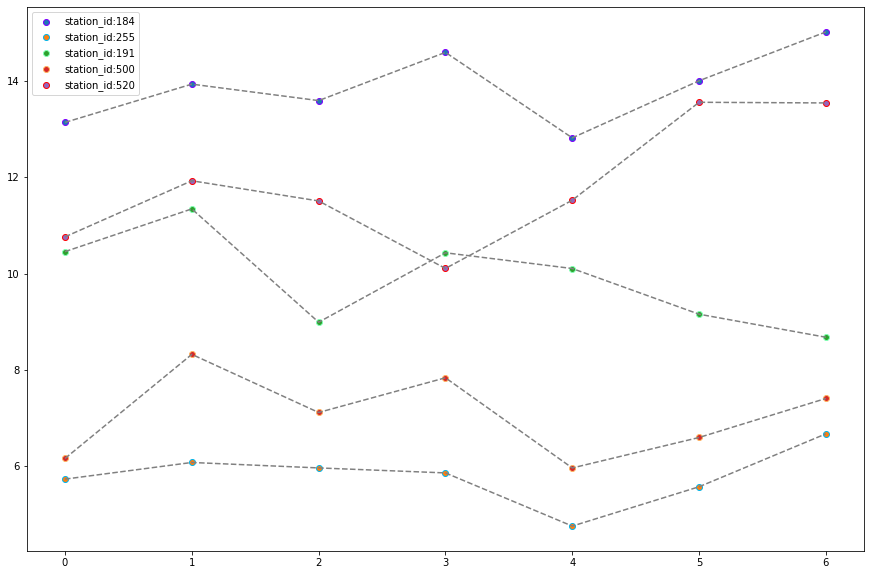

In [23]:
%%time

scatter_columns(
    data[config_year.year], 
    'dayofweek', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofweek']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 3408, 'mean': 3383.246062992126, 'median': 3408.0, 'std': 192.40389512743508, 'min': 432}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.02 s, sys: 105 ms, total: 1.12 s
Wall time: 5.84 s


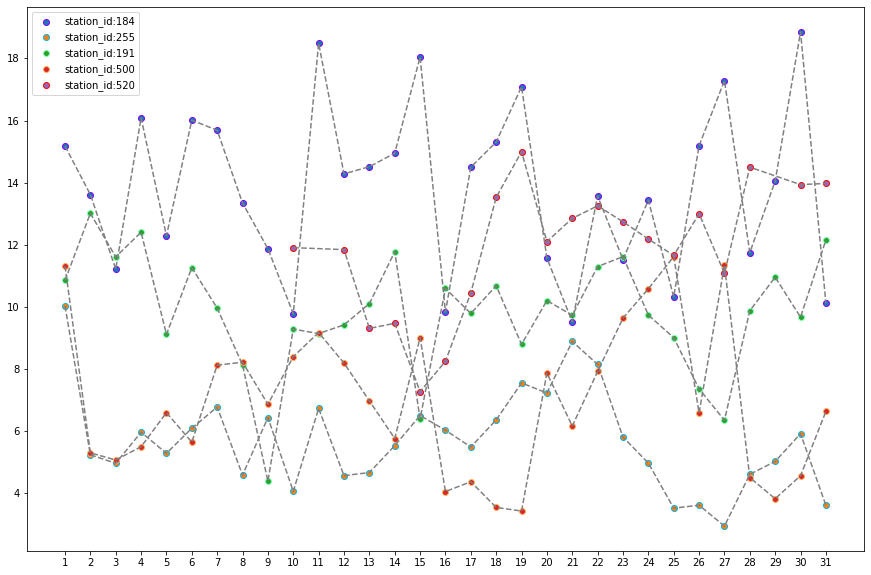

In [24]:
%%time

# mean for all months
scatter_columns(data[config_year.year], 'day', 'num_bikes_available', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['day']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 680, 'mean': 680.0, 'median': 680.0, 'std': nan, 'min': 680}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': nan, 'mean': nan, 'median': nan, 'std': nan, 'min': nan}


0it [00:00, ?it/s]

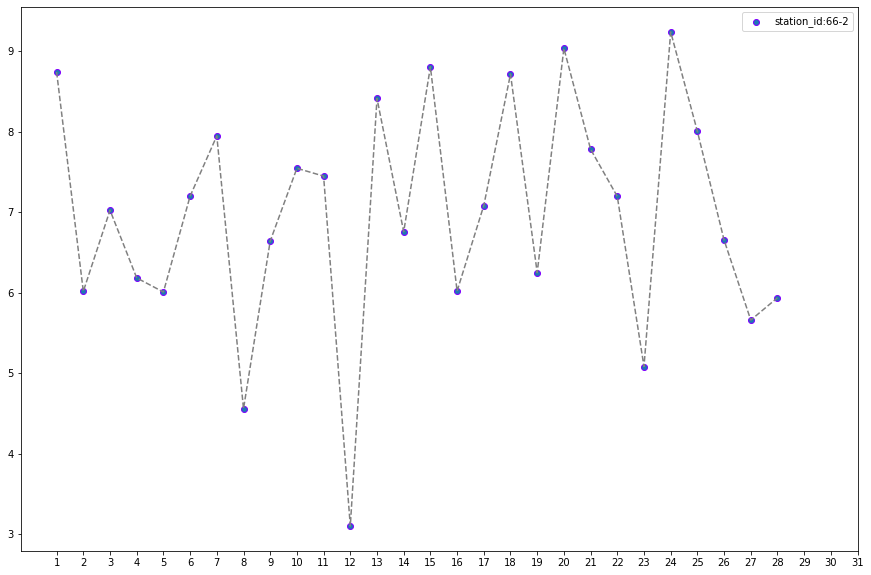

CPU times: user 551 ms, sys: 68.3 ms, total: 620 ms
Wall time: 2.95 s


In [25]:
%%time

station_of_interest = 66

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 680, 'mean': 680.0, 'median': 680.0, 'std': nan, 'min': 680}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': nan, 'mean': nan, 'median': nan, 'std': nan, 'min': nan}


0it [00:00, ?it/s]

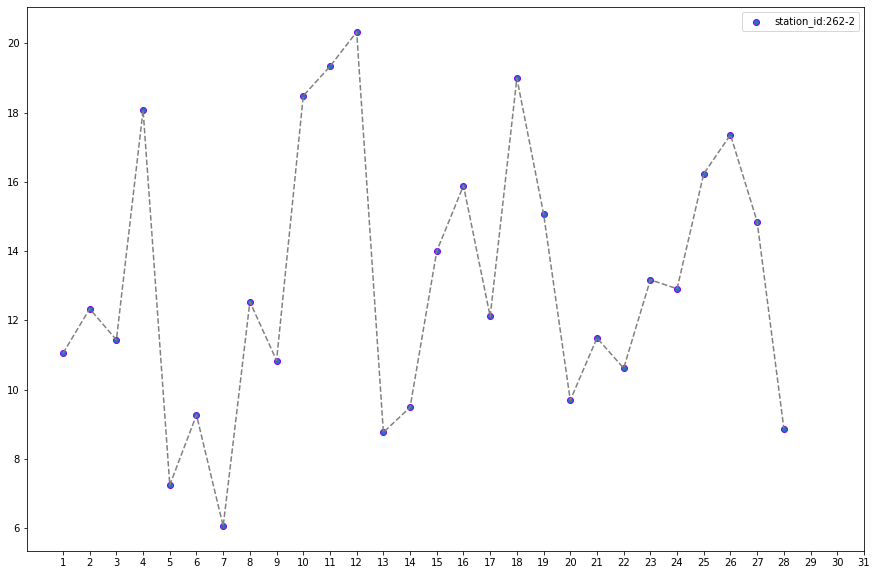

CPU times: user 631 ms, sys: 77.2 ms, total: 708 ms
Wall time: 3.14 s


In [26]:
%%time

station_of_interest = 262

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 3408, 'mean': 3383.246062992126, 'median': 3408.0, 'std': 192.40389512743508, 'min': 432}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 874 ms, sys: 98.7 ms, total: 973 ms
Wall time: 5.85 s


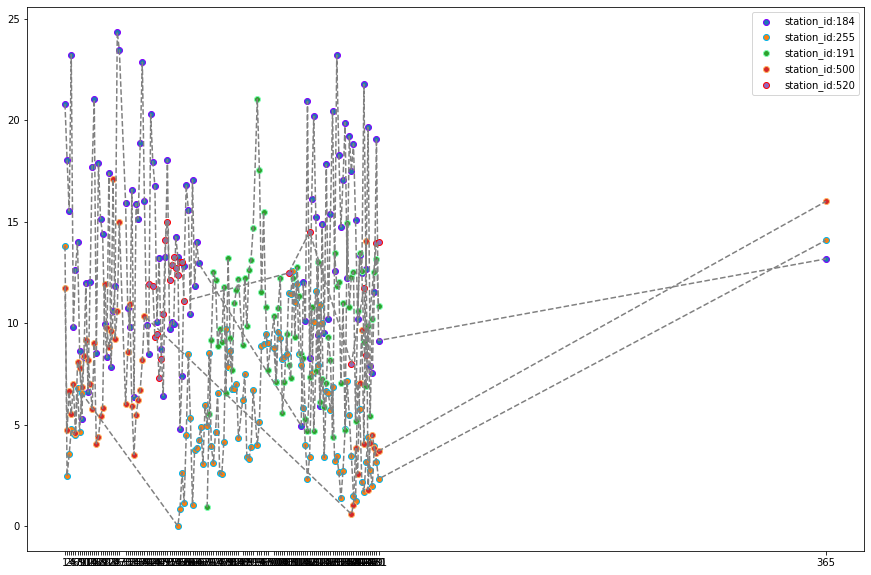

In [27]:
%%time

scatter_columns(data[config_year.year], 'dayofyear', 'num_bikes_available', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofyear']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 3408, 'mean': 3383.246062992126, 'median': 3408.0, 'std': 192.40389512743508, 'min': 432}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 692 ms, sys: 67.6 ms, total: 760 ms
Wall time: 5.43 s


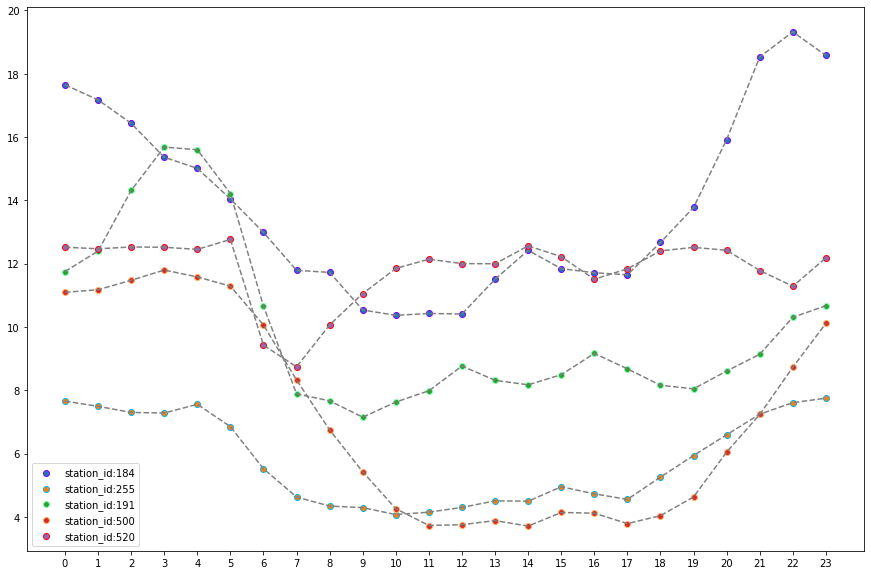

In [28]:
%%time

scatter_columns(data[config_year.year], 'hour', 'num_bikes_available', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': nan, 'mean': nan, 'median': nan, 'std': nan, 'min': nan}


0it [00:00, ?it/s]

No handles with labels found to put in legend.


CPU times: user 116 ms, sys: 36.3 ms, total: 152 ms
Wall time: 886 ms


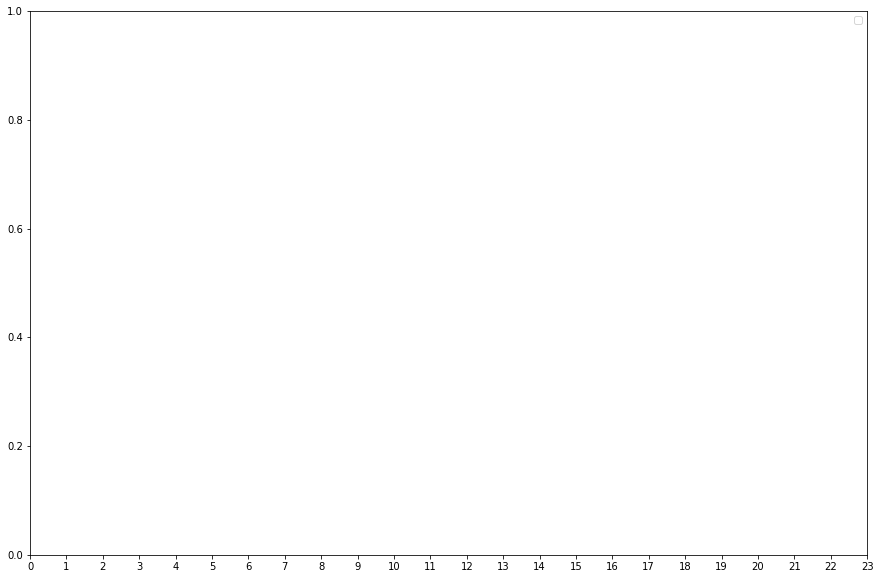

In [29]:
%%time

day_of_interest = 200
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 24, 'mean': 24.0, 'median': 24.0, 'std': 0.0, 'min': 24}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 737 ms, sys: 21.2 ms, total: 759 ms
Wall time: 5.45 s


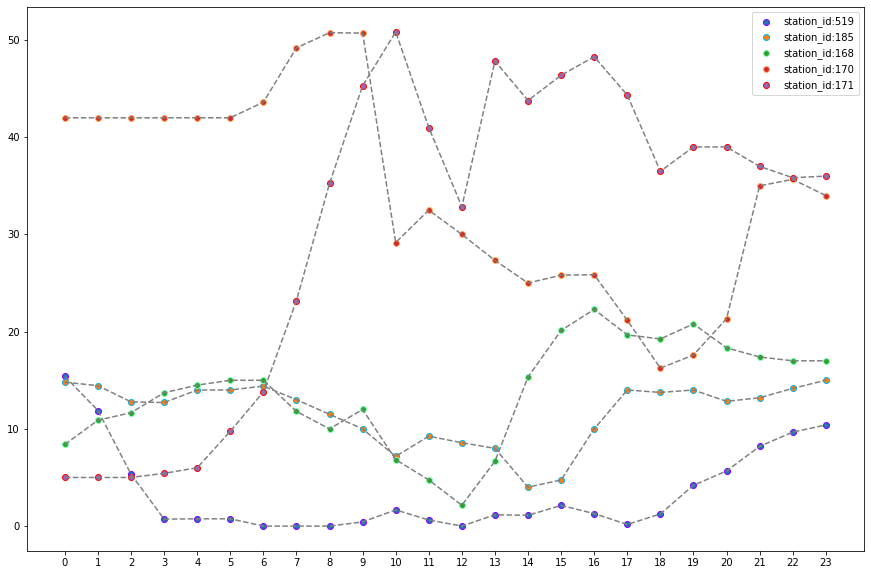

In [30]:
%%time

# https://es.wikipedia.org/wiki/23_de_abril  
# data[config_year.year][data[config_year.year].dayofyear_last_updated_date == 113]

day_of_interest = 113
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'num_bikes_available', 
    'station_id', 
    tail=False,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 483, 'mean': 483.0, 'median': 483.0, 'std': nan, 'min': 483}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 527, 'mean': 527.0, 'median': 527.0, 'std': nan, 'min': 527}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 536, 'mean': 536.0, 'median': 536.0, 'std': nan, 'min': 536}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 504, 'mean': 504.0, 'median': 504.0, 'std': nan, 'min': 504}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 486, 'mean': 486.0, 'median': 486.0, 'std': nan, 'min': 486}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 443, 'mean': 443.0, 'median': 443.0, 'std': nan, 'min': 443}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 429, 'mean': 429.0, 'median': 429.0, 'std': nan, 'min': 429}


  0%|          | 0/1 [00:00<?, ?it/s]

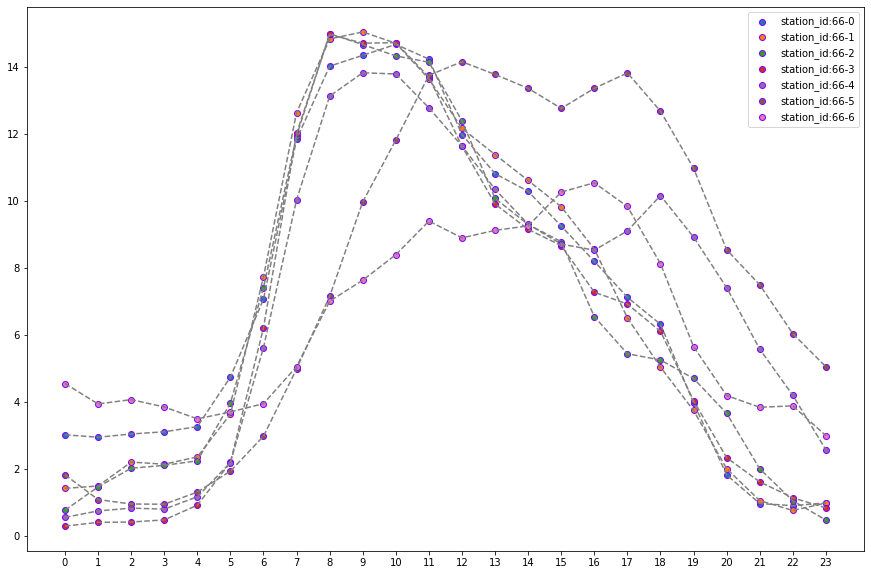

CPU times: user 2.25 s, sys: 188 ms, total: 2.43 s
Wall time: 13.4 s


In [31]:
%%time

station_of_interest = 66

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 483, 'mean': 483.0, 'median': 483.0, 'std': nan, 'min': 483}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 527, 'mean': 527.0, 'median': 527.0, 'std': nan, 'min': 527}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 536, 'mean': 536.0, 'median': 536.0, 'std': nan, 'min': 536}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 504, 'mean': 504.0, 'median': 504.0, 'std': nan, 'min': 504}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 486, 'mean': 486.0, 'median': 486.0, 'std': nan, 'min': 486}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 443, 'mean': 443.0, 'median': 443.0, 'std': nan, 'min': 443}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 429, 'mean': 429.0, 'median': 429.0, 'std': nan, 'min': 429}


  0%|          | 0/1 [00:00<?, ?it/s]

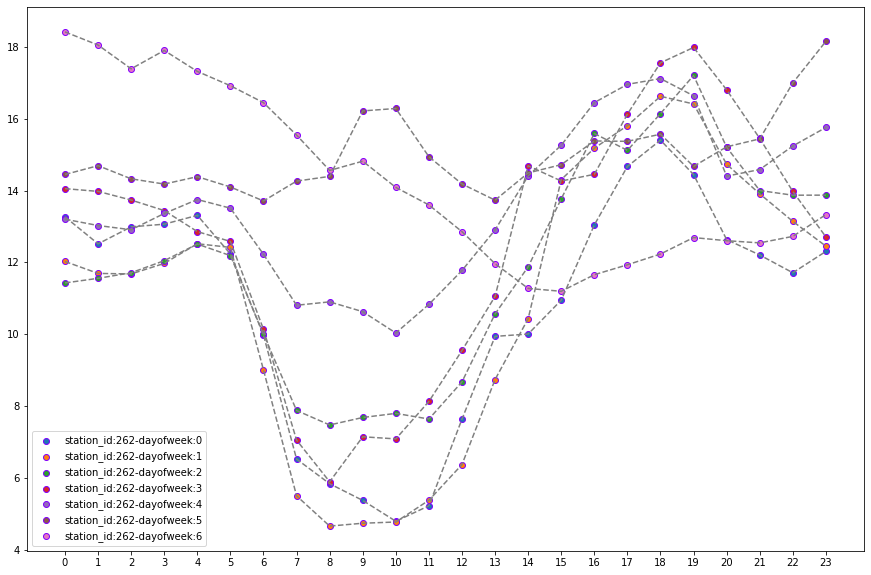

CPU times: user 1.82 s, sys: 286 ms, total: 2.11 s
Wall time: 13.4 s


In [32]:
%%time

station_of_interest = 262

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'dayofweek:{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

## 2022 is_charging_station

In [33]:
%%time

print(stats.describe(data[config_year.year].is_charging_station))
data[config_year.year].is_charging_station.describe().compute()

DescribeResult(nobs=1718689, minmax=(1, 1), mean=1.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
CPU times: user 279 ms, sys: 27.9 ms, total: 307 ms
Wall time: 1.78 s


count    1718689.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: is_charging_station, dtype: float64

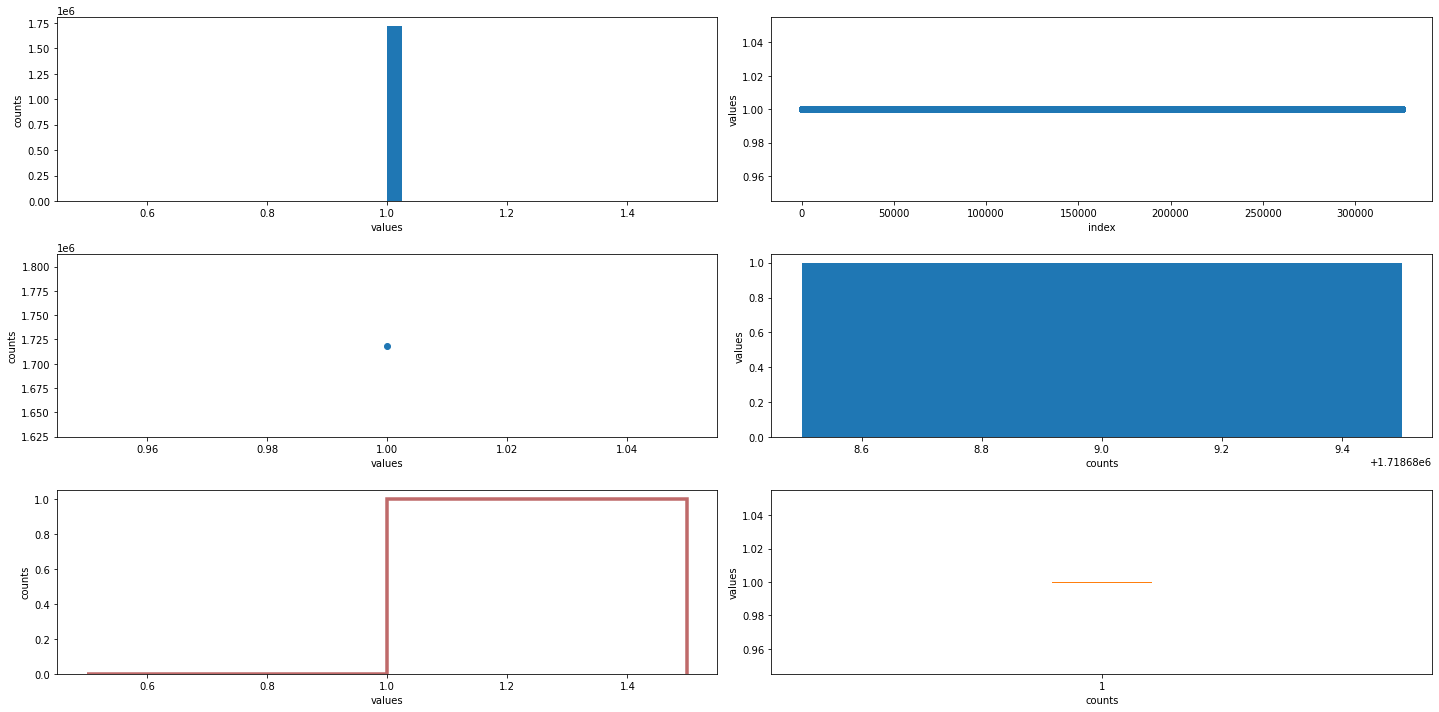

CPU times: user 2.88 s, sys: 286 ms, total: 3.16 s
Wall time: 3.71 s


In [34]:
%%time

show_counts(data[config_year.year].is_charging_station.compute())

## 2022 status

In [35]:
%%time

print(stats.describe(data[config_year.year].status))
data[config_year.year].status.describe().compute()

DescribeResult(nobs=1718689, minmax=(0, 3), mean=0.0006446774256424519, variance=0.0007082645002539069, skewness=45.79730751955541, kurtosis=2504.854359404643)
CPU times: user 292 ms, sys: 14.7 ms, total: 307 ms
Wall time: 1.83 s


count    1.718689e+06
mean     6.446774e-04
std      2.661324e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.000000e+00
Name: status, dtype: float64

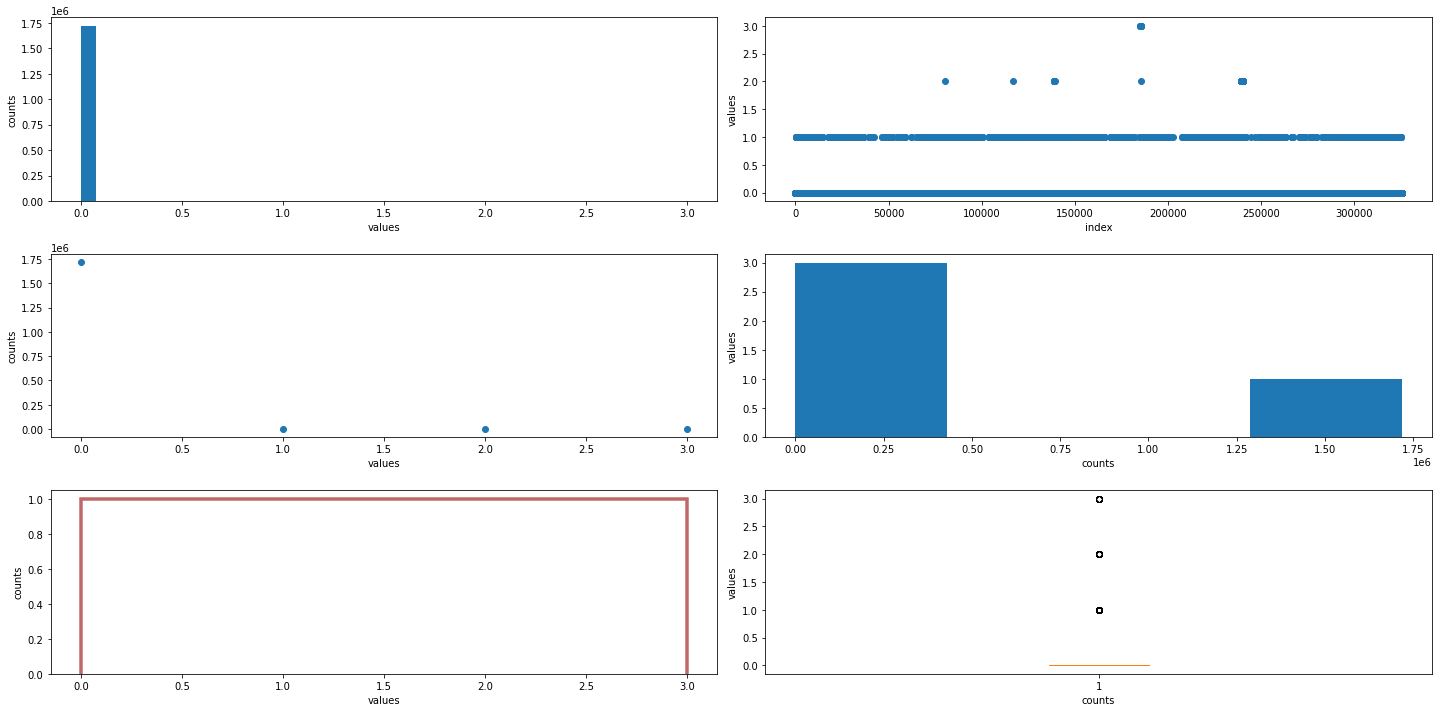

CPU times: user 2.86 s, sys: 310 ms, total: 3.17 s
Wall time: 3.78 s


In [36]:
%%time

show_counts(data[config_year.year].status.compute())

## 2022 is_installed

In [37]:
%%time

print(stats.describe(data[config_year.year].is_installed))
data[config_year.year].is_installed.describe().compute()

DescribeResult(nobs=1718689, minmax=(0, 1), mean=0.9999947634505137, variance=5.2365251116285365e-06, skewness=-436.9924993059756, kurtosis=190960.4444496809)
CPU times: user 369 ms, sys: 49.6 ms, total: 418 ms
Wall time: 1.97 s


count    1.718689e+06
mean     9.999948e-01
std      2.288345e-03
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: is_installed, dtype: float64

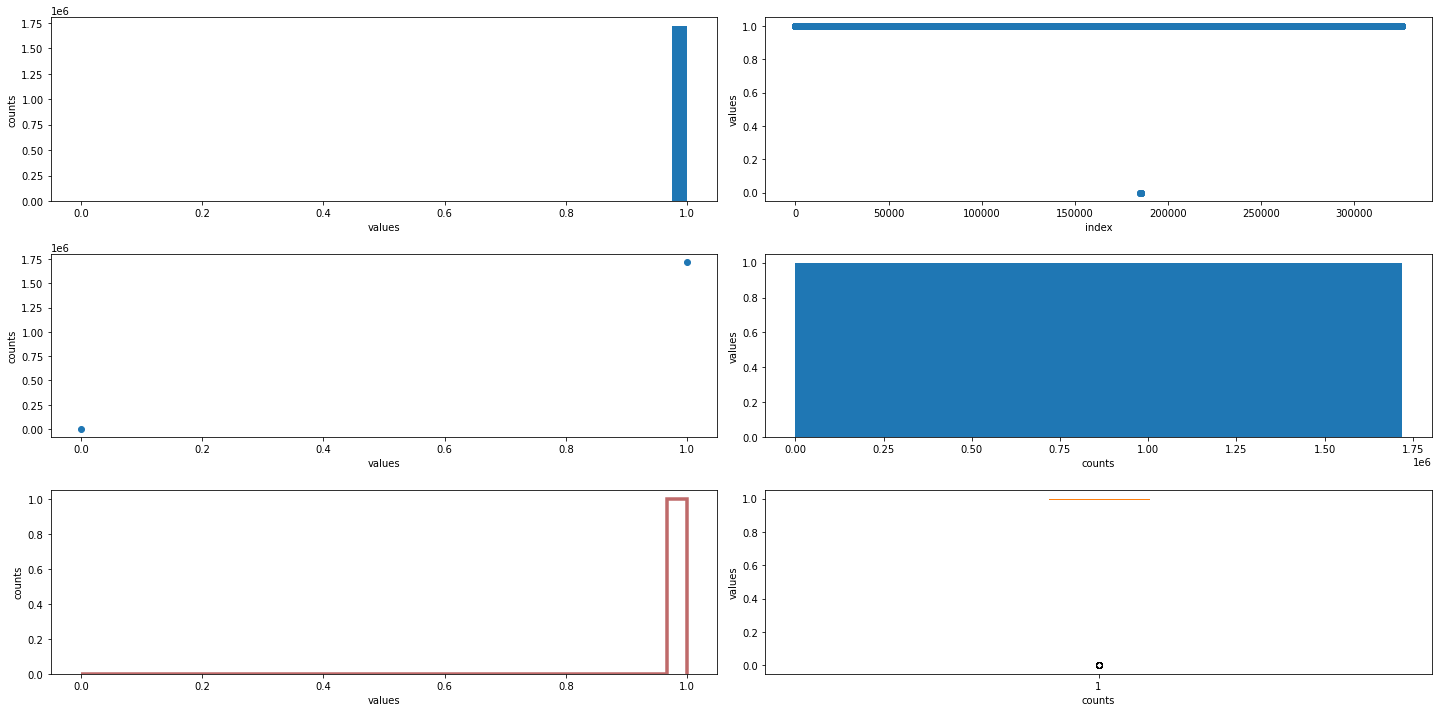

CPU times: user 2.74 s, sys: 246 ms, total: 2.98 s
Wall time: 3.53 s


In [38]:
%%time

show_counts(data[config_year.year].is_installed.compute())

## 2022 is_renting

In [39]:
%%time

print(stats.describe(data[config_year.year].is_renting))
data[config_year.year].is_renting.describe().compute()

DescribeResult(nobs=1718689, minmax=(0, 1), mean=0.999293647658186, variance=0.0007058538188763965, skewness=-37.58623098383133, kurtosis=1410.724759569918)
CPU times: user 265 ms, sys: 54.3 ms, total: 320 ms
Wall time: 1.86 s


count    1.718689e+06
mean     9.992936e-01
std      2.656791e-02
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: is_renting, dtype: float64

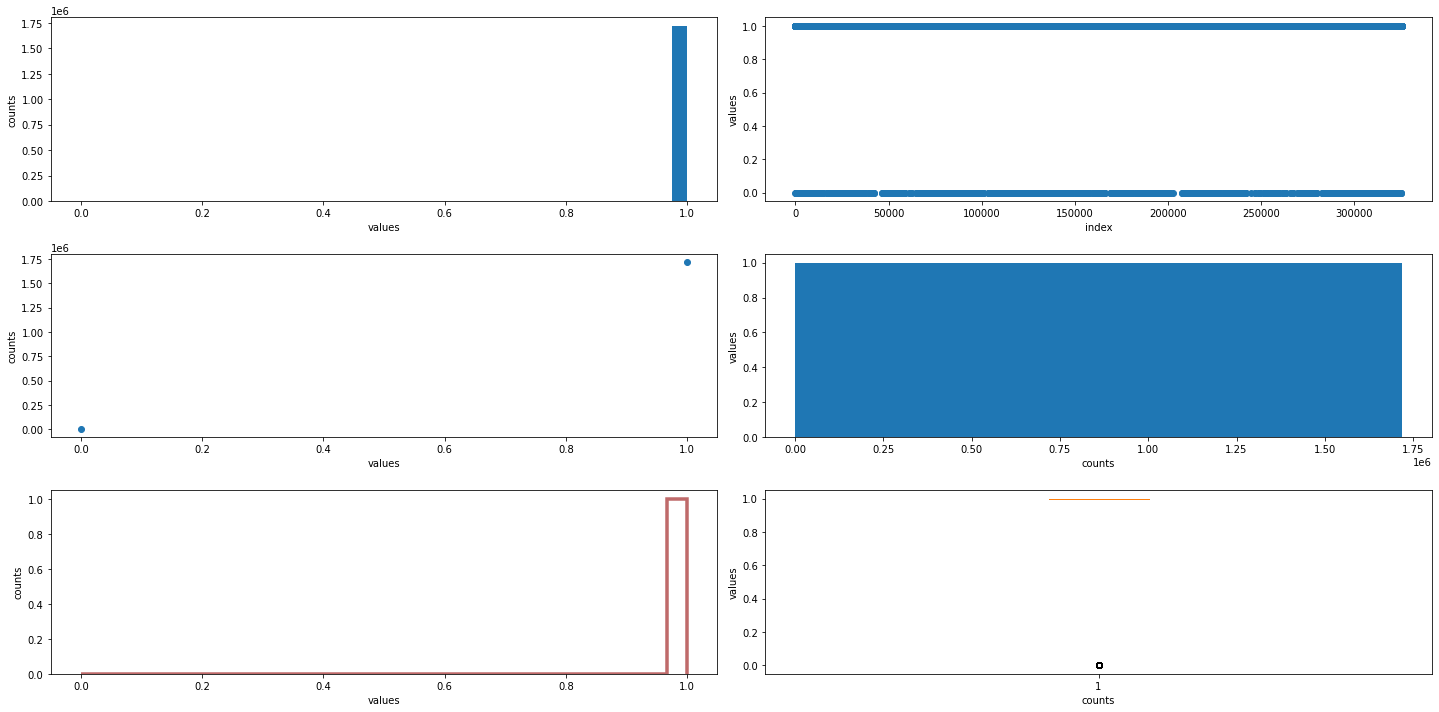

CPU times: user 2.81 s, sys: 289 ms, total: 3.1 s
Wall time: 3.63 s


In [40]:
%%time

show_counts(data[config_year.year].is_renting.compute())

## 2022 is_returning

In [41]:
%%time

print(stats.describe(data[config_year.year].is_returning))
data[config_year.year].is_returning.describe().compute()

DescribeResult(nobs=1718689, minmax=(0, 1), mean=0.9992942294970177, variance=0.000705272801334438, skewness=-37.601753751178485, kurtosis=1411.8918851642686)
CPU times: user 289 ms, sys: 21.4 ms, total: 310 ms
Wall time: 1.84 s


count    1.718689e+06
mean     9.992942e-01
std      2.655697e-02
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: is_returning, dtype: float64

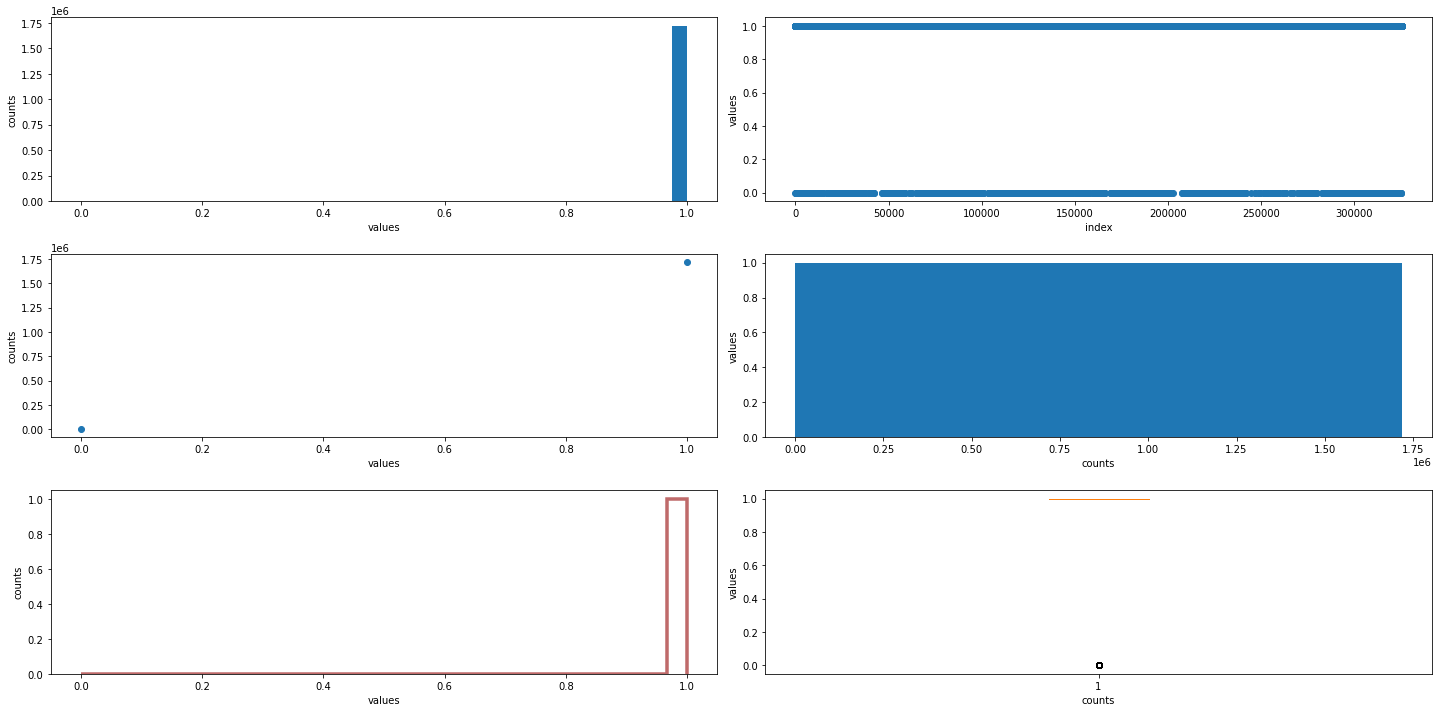

CPU times: user 2.74 s, sys: 290 ms, total: 3.03 s
Wall time: 3.59 s


In [42]:
%%time

show_counts(data[config_year.year].is_returning.compute())

## 2022 ctx0

In [43]:
%%time

print(stats.describe(data[config_year.year].ctx0))
data[config_year.year].ctx0.describe().compute()

DescribeResult(nobs=1718689, minmax=(0.0, 1.0), mean=0.5768128112713848, variance=0.07197259369629745, skewness=-0.3816661786191092, kurtosis=-0.8950498499490998)
CPU times: user 256 ms, sys: 48.7 ms, total: 305 ms
Wall time: 1.83 s


count    1.718689e+06
mean     5.768128e-01
std      2.682771e-01
min      0.000000e+00
25%      4.537037e-01
50%      7.058824e-01
75%      8.563657e-01
max      1.000000e+00
Name: ctx0, dtype: float64

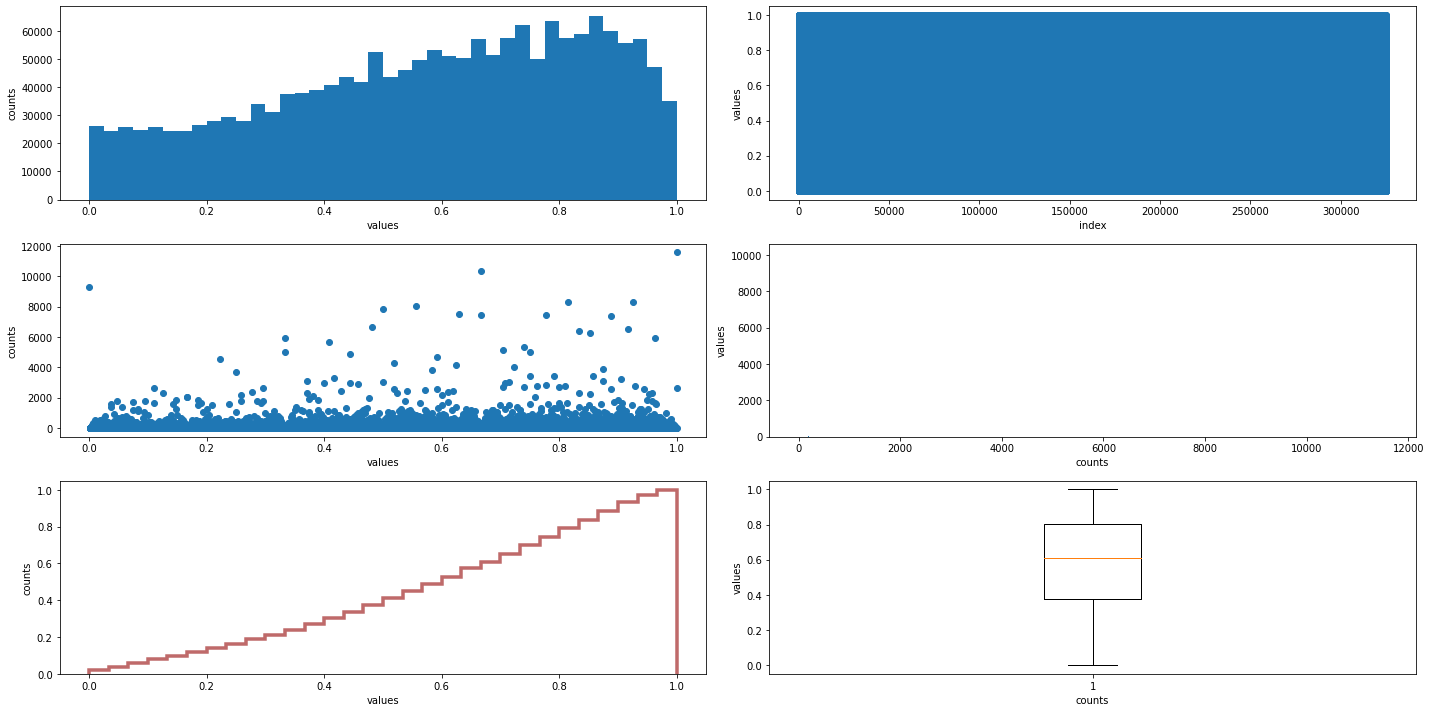

CPU times: user 57.6 s, sys: 11.9 s, total: 1min 9s
Wall time: 1min 8s


In [44]:
%%time

show_counts(data[config_year.year].ctx0.compute())

135
value counts stats {'max': 3408, 'mean': 3383.246062992126, 'median': 3408.0, 'std': 192.40389512743508, 'min': 432}


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 321 ms, sys: 44.2 ms, total: 365 ms
Wall time: 1.89 s


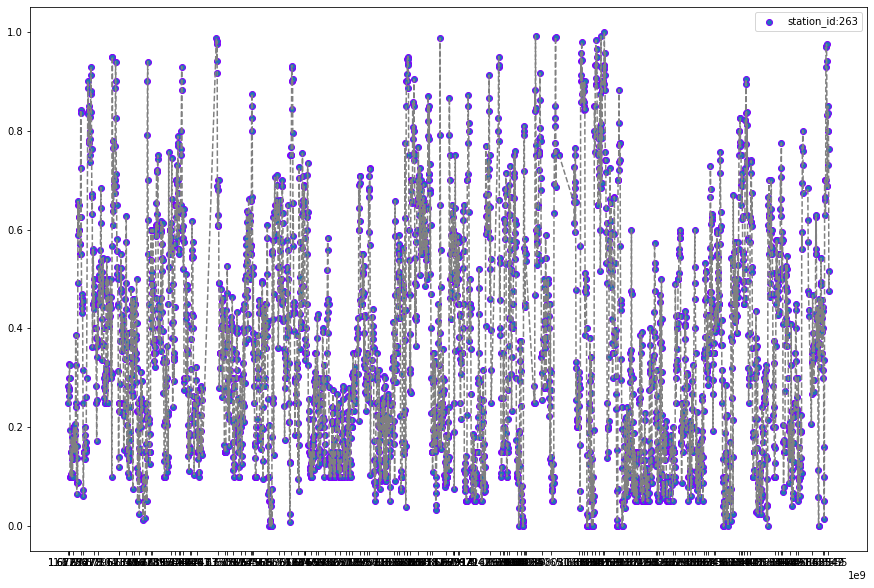

In [45]:
%%time

# Checking availibilty for docks all year
xtikcs_scatter = [uniques['timestamp'][i] for i, x in enumerate(uniques['timestamp']) if i%25==0]
print(len(xtikcs_scatter))

scatter_columns(
    data[config_year.year], 
    'timestamp', 
    'ctx0', 
    'station_id', 
    tail=False,
    xticks=np.asarray(xtikcs_scatter),
    figsize=(15,10),
    count=1
)


value counts stats {'max': 3408, 'mean': 3383.246062992126, 'median': 3408.0, 'std': 192.40389512743508, 'min': 432}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 648 ms, sys: 79.1 ms, total: 728 ms
Wall time: 5.31 s


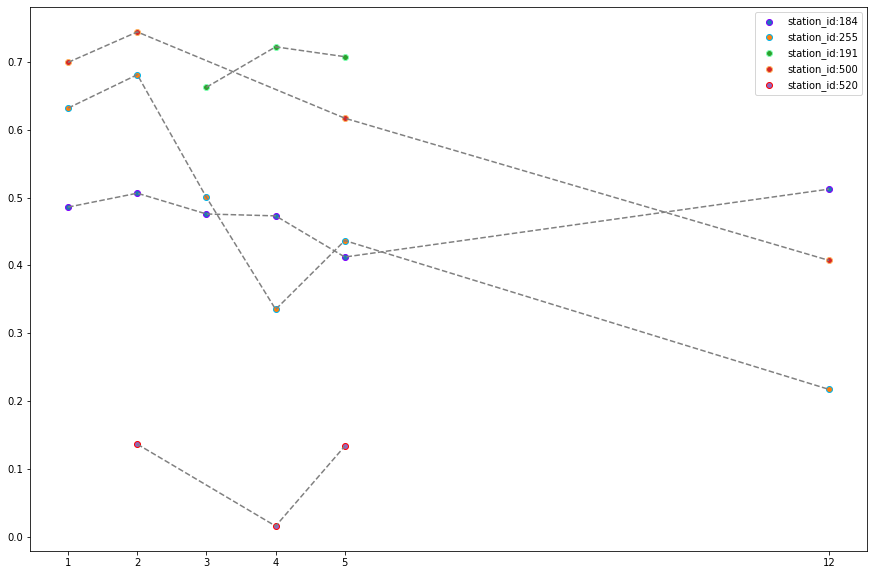

In [46]:
%%time

scatter_columns(
    data[config_year.year], 
    'month', 
    'ctx0', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['month']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 3408, 'mean': 3383.246062992126, 'median': 3408.0, 'std': 192.40389512743508, 'min': 432}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 697 ms, sys: 86.6 ms, total: 784 ms
Wall time: 5.57 s


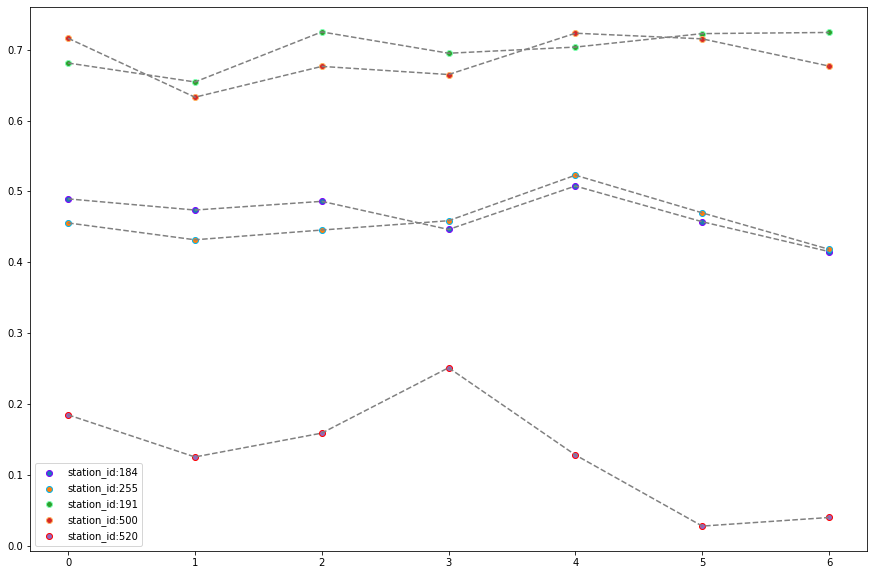

In [47]:
%%time

scatter_columns(
    data[config_year.year], 
    'dayofweek', 
    'ctx0', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofweek']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 3408, 'mean': 3383.246062992126, 'median': 3408.0, 'std': 192.40389512743508, 'min': 432}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 3.74 s, sys: 63.1 ms, total: 3.8 s
Wall time: 8.42 s


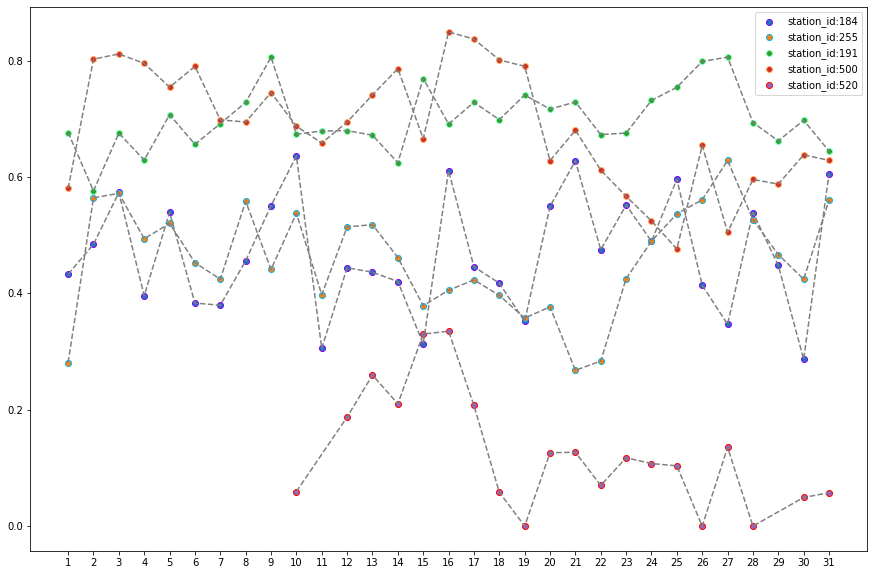

In [48]:
%%time

# mean for all months
scatter_columns(data[config_year.year], 'day', 'ctx0', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['day']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 680, 'mean': 680.0, 'median': 680.0, 'std': nan, 'min': 680}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': nan, 'mean': nan, 'median': nan, 'std': nan, 'min': nan}


0it [00:00, ?it/s]

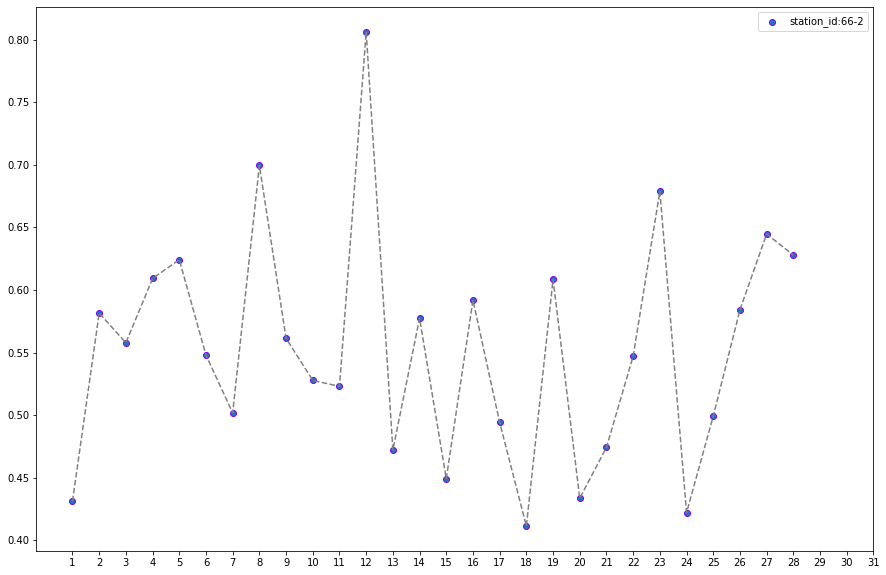

CPU times: user 571 ms, sys: 91.8 ms, total: 663 ms
Wall time: 2.98 s


In [49]:
%%time

station_of_interest = 66

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 680, 'mean': 680.0, 'median': 680.0, 'std': nan, 'min': 680}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': nan, 'mean': nan, 'median': nan, 'std': nan, 'min': nan}


0it [00:00, ?it/s]

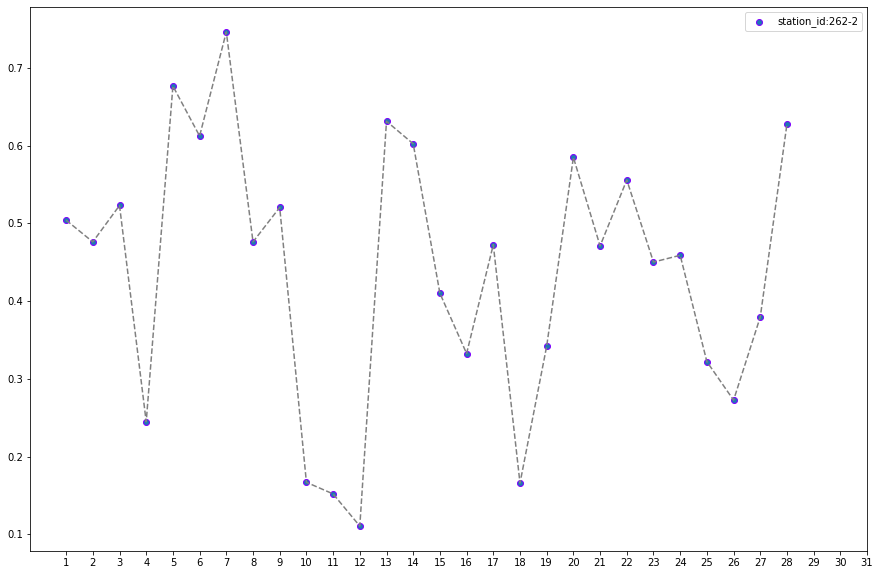

CPU times: user 539 ms, sys: 56.7 ms, total: 596 ms
Wall time: 2.97 s


In [50]:
%%time

station_of_interest = 262

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 3408, 'mean': 3383.246062992126, 'median': 3408.0, 'std': 192.40389512743508, 'min': 432}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 820 ms, sys: 57.3 ms, total: 877 ms
Wall time: 5.6 s


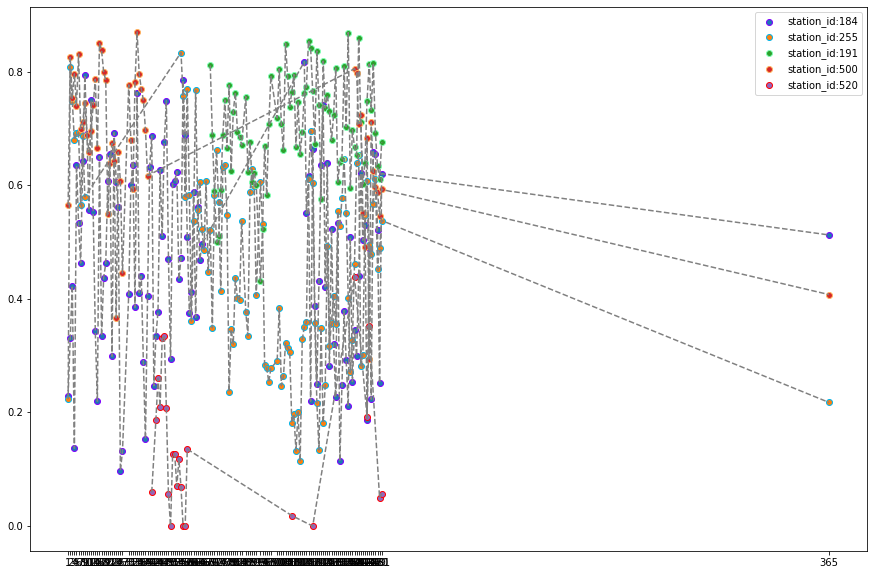

In [51]:
%%time

scatter_columns(data[config_year.year], 'dayofyear', 'ctx0', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofyear']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 3408, 'mean': 3383.246062992126, 'median': 3408.0, 'std': 192.40389512743508, 'min': 432}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 701 ms, sys: 52.7 ms, total: 754 ms
Wall time: 5.39 s


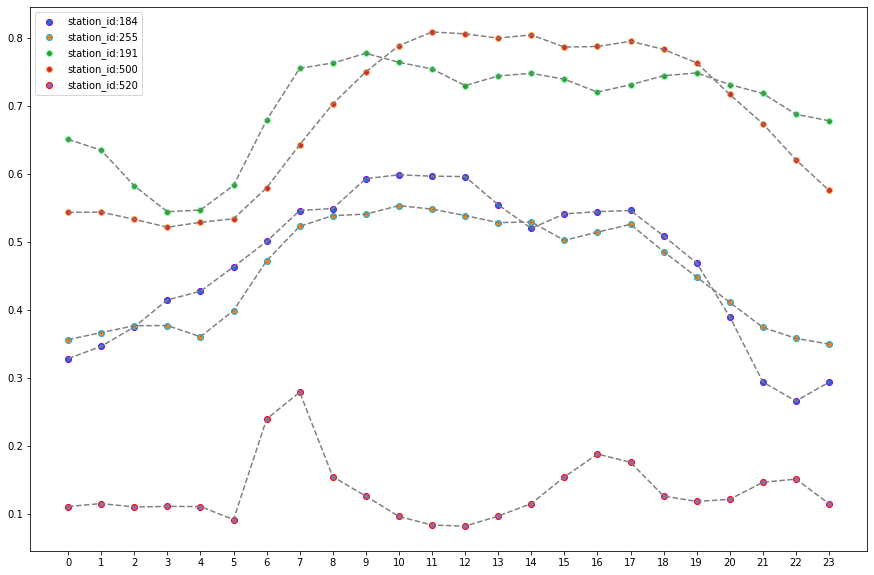

In [52]:
%%time

scatter_columns(data[config_year.year], 'hour', 'ctx0', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': nan, 'mean': nan, 'median': nan, 'std': nan, 'min': nan}


0it [00:00, ?it/s]

No handles with labels found to put in legend.


CPU times: user 141 ms, sys: 20.1 ms, total: 161 ms
Wall time: 918 ms


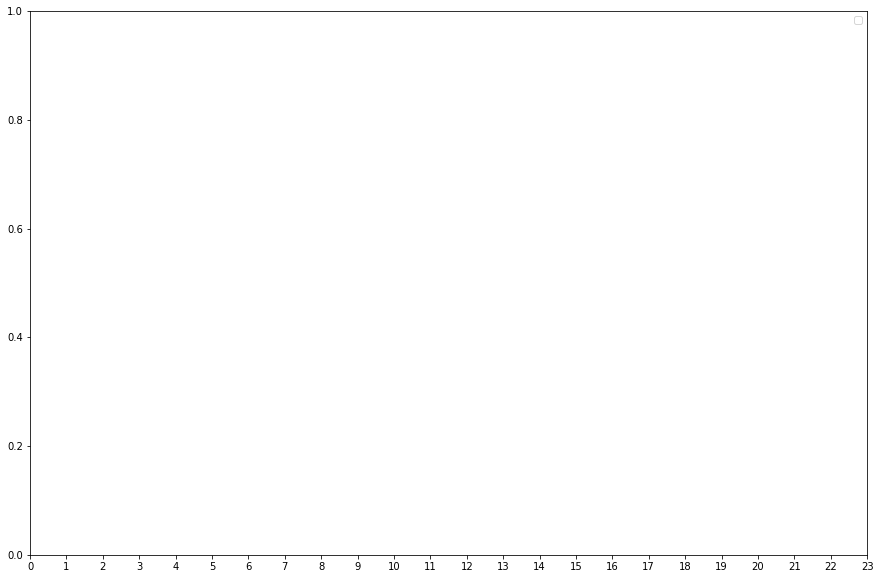

In [53]:
%%time

day_of_interest = 200
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'ctx0', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 24, 'mean': 24.0, 'median': 24.0, 'std': 0.0, 'min': 24}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 688 ms, sys: 68.6 ms, total: 757 ms
Wall time: 5.41 s


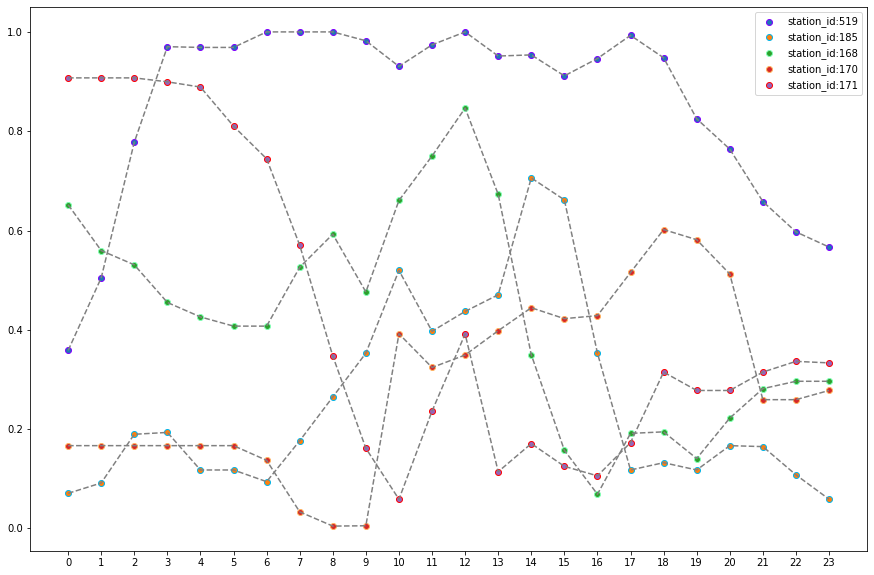

In [54]:
%%time

# https://es.wikipedia.org/wiki/23_de_abril  
# data[config_year.year][data[config_year.year].dayofyear_last_updated_date == 113]

day_of_interest = 113
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'ctx0', 
    'station_id', 
    tail=False,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 483, 'mean': 483.0, 'median': 483.0, 'std': nan, 'min': 483}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 527, 'mean': 527.0, 'median': 527.0, 'std': nan, 'min': 527}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 536, 'mean': 536.0, 'median': 536.0, 'std': nan, 'min': 536}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 504, 'mean': 504.0, 'median': 504.0, 'std': nan, 'min': 504}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 486, 'mean': 486.0, 'median': 486.0, 'std': nan, 'min': 486}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 443, 'mean': 443.0, 'median': 443.0, 'std': nan, 'min': 443}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 429, 'mean': 429.0, 'median': 429.0, 'std': nan, 'min': 429}


  0%|          | 0/1 [00:00<?, ?it/s]

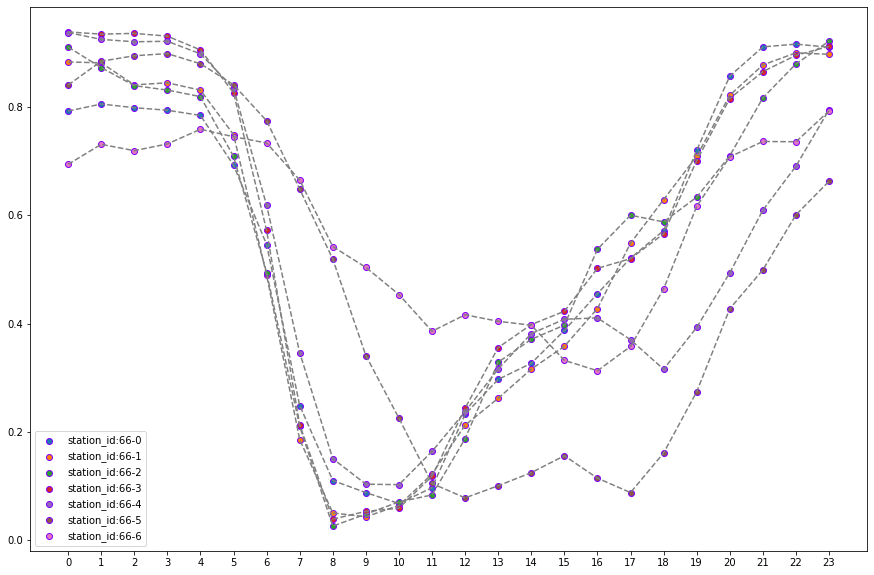

CPU times: user 1.96 s, sys: 277 ms, total: 2.23 s
Wall time: 13.1 s


In [55]:
%%time

station_of_interest = 66

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 483, 'mean': 483.0, 'median': 483.0, 'std': nan, 'min': 483}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 527, 'mean': 527.0, 'median': 527.0, 'std': nan, 'min': 527}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 536, 'mean': 536.0, 'median': 536.0, 'std': nan, 'min': 536}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 504, 'mean': 504.0, 'median': 504.0, 'std': nan, 'min': 504}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 486, 'mean': 486.0, 'median': 486.0, 'std': nan, 'min': 486}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 443, 'mean': 443.0, 'median': 443.0, 'std': nan, 'min': 443}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 429, 'mean': 429.0, 'median': 429.0, 'std': nan, 'min': 429}


  0%|          | 0/1 [00:00<?, ?it/s]

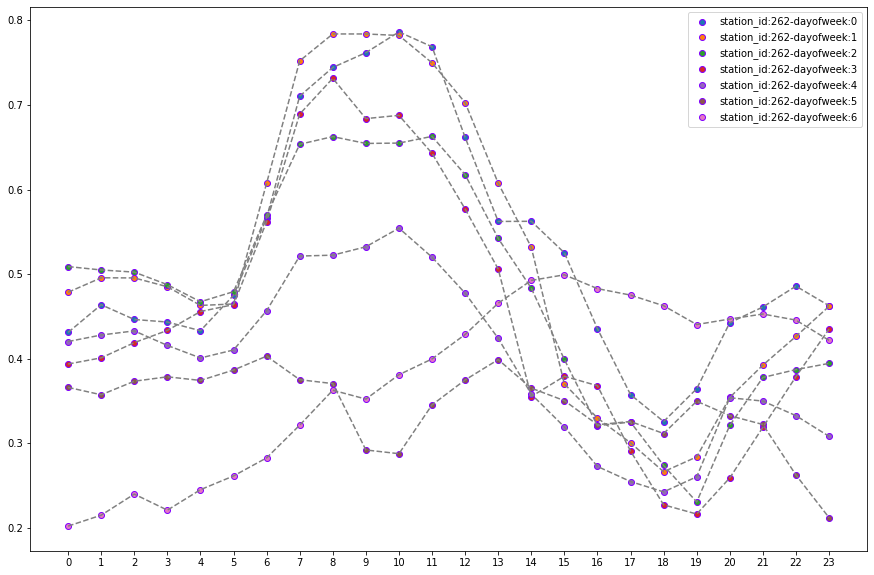

CPU times: user 1.95 s, sys: 167 ms, total: 2.12 s
Wall time: 13.2 s


In [56]:
%%time

station_of_interest = 262

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'dayofweek:{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()